In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [4]:
# get data
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


In [6]:
# Visualize
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [7]:
# preprocessing data (one-hot encoding batch-size 1)
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [12]:
# RNN model 
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [15]:
# test run 
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

tensor([[-0.0008, -0.0685, -0.0167, -0.0332,  0.0518,  0.0119, -0.0267,  0.0425,
         -0.0849, -0.0615,  0.0226, -0.0512,  0.0104,  0.0569,  0.0590,  0.0067,
          0.0738, -0.1149, -0.0480, -0.0089,  0.0348,  0.0293, -0.0535, -0.0279,
         -0.0343, -0.0450, -0.0734,  0.0212, -0.0585,  0.0893, -0.0360, -0.0239,
          0.0347, -0.0980, -0.0721, -0.0873,  0.0270, -0.0305, -0.0923, -0.0220,
          0.0319,  0.0545,  0.0188, -0.0895, -0.0968, -0.0570, -0.0094,  0.0315,
          0.0392,  0.0653, -0.0048, -0.0268,  0.0119, -0.0265,  0.0160,  0.0308,
          0.0812, -0.0295,  0.0112, -0.0068,  0.0958, -0.0180, -0.0962, -0.0214,
         -0.1032, -0.0145, -0.0944,  0.0355,  0.0237, -0.0176, -0.0296, -0.0773,
          0.0272, -0.0199, -0.0201,  0.0137, -0.0606, -0.0162, -0.0135,  0.1080,
          0.1311,  0.0382,  0.0955,  0.0078,  0.0360, -0.0434, -0.0202, -0.0338,
         -0.0019, -0.0511, -0.0141,  0.0361,  0.0363,  0.0020, -0.0297,  0.1152,
         -0.0330,  0.0010,  

In [18]:
# Test run 
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output) # hidden state for first letter used as input for the next letter 

tensor([[-2.9143, -2.9946, -2.7739, -2.9904, -2.9193, -2.9284, -2.8456, -2.9042,
         -2.8630, -2.9112, -2.9128, -2.8375, -2.8792, -2.8571, -2.8690, -3.0184,
         -2.7825, -2.8624]], grad_fn=<LogSoftmaxBackward0>)


tensor([2])

In [21]:
# Get category from output 
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Arabic', 2)


In [22]:
# Random training example  
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Scottish / line = Mckenzie
category = Spanish / line = Olguin
category = Arabic / line = Deeb
category = Chinese / line = Gwock
category = Dutch / line = Ven
category = Dutch / line = Specht
category = Italian / line = Segreti
category = German / line = Lafrentz
category = Japanese / line = Hamacho
category = English / line = Hamer


In [23]:
# Loss function 
criterion = nn.NLLLoss()

In [25]:
# Train function 
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [26]:
# train
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.8203 Quigley / German ✗ (English)
10000 10% (0m 9s) 1.6609 Robert / French ✓
15000 15% (0m 13s) 1.8797 Kollen / Dutch ✓
20000 20% (0m 17s) 1.6212 Conneely / English ✓
25000 25% (0m 21s) 2.4021 Soukup / Arabic ✗ (Czech)
30000 30% (0m 25s) 0.6191 O'Reilly / Irish ✓
35000 35% (0m 28s) 1.8501 Batsevich / Czech ✗ (Russian)
40000 40% (0m 32s) 0.5477 Milionis / Greek ✓
45000 45% (0m 35s) 4.6435 Lyon / Korean ✗ (French)
50000 50% (0m 38s) 0.7115 Kowalski / Polish ✓
55000 55% (0m 43s) 1.5807 Delgado / Italian ✗ (Portuguese)
60000 60% (0m 47s) 3.4084 Kim / Korean ✗ (Vietnamese)
65000 65% (0m 51s) 4.0597 Jung / Korean ✗ (German)
70000 70% (0m 55s) 2.4529 Crook / Scottish ✗ (English)
75000 75% (0m 59s) 0.4013 Qiu / Chinese ✓
80000 80% (1m 3s) 0.7707 Cui / Chinese ✓
85000 85% (1m 6s) 1.5696 She / Korean ✗ (Chinese)
90000 90% (1m 10s) 3.2117 Farrell / Spanish ✗ (Irish)
95000 95% (1m 14s) 1.4388 Teoh / Arabic ✗ (Chinese)
100000 100% (1m 17s) 0.4850 Mcintyre / Scottish ✓


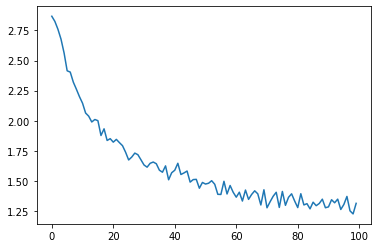

In [27]:
# results
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/Users/alanwang/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/alanwang/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


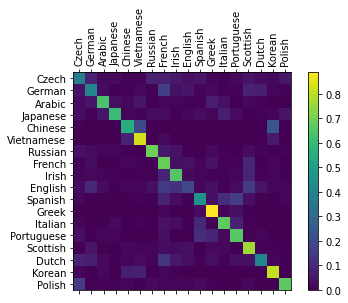

In [28]:
# Evaluation
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [36]:
# Inference 
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('hello')
predict('wang')


> Dovesky
(-0.30) Russian
(-1.84) Czech
(-3.49) Irish

> Jackson
(-0.15) Scottish
(-3.02) English
(-3.37) Russian

> Satoshi
(-1.36) Italian
(-1.59) Arabic
(-1.66) Japanese

> hello
(-1.27) Italian
(-1.37) Spanish
(-2.18) Scottish

> wang
(-0.80) Korean
(-1.00) Chinese
(-2.79) Vietnamese
